# Pyiron workflows: quickstart

You can start converting python functions to `pyiron_workflow` nodes by wrapping them with decorators accessible from our single-point-of-entry, the `Workflow` class:

In [1]:
from pyiron_workflow import Workflow

## From function to node

Let's start with a super simple function that only returns a single thing

In [2]:
@Workflow.wrap.as_function_node()
def AddOne(x):
    y = x + 1
    return y

node = AddOne()

This node object can be run just like the function it wraps

In [3]:
node(42)

43

But is also a class instance with input and output channels (note that here the output value takes its name based on what came after the `return` statement)

In [4]:
node.inputs.x = 0
node.run()
node.outputs.y.value

1

So other than being delayed, these nodes behave a _lot_ like the regular python functions that wrap them. E.g. we can nest them together just like a regular function:

In [5]:
calculation = AddOne(AddOne(AddOne(2)))
calculation()

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel run was not connected to ran, andthus could not disconnect from it.
  warn(


5

But they are actually nodes, and what we saw above is just syntactic sugar for building a _graph_ connecting the inputs and outputs of the nodes:

In [6]:
n1 = AddOne()
n2 = AddOne()
n3 = AddOne()

n2.inputs.x = n1.outputs.y
n3.inputs.x = n2.outputs.y

n1.inputs.x = 0
n3()

3

In the special case that a node has only _one_ output channel (i.e. only one return value in the decorated function), this object will fall back on trying to perform operations on that output channel! Combining this with the syntactic sugar for using the function signature to set input values, we can equivalently write the example above as:

In [7]:
n1 = AddOne(x=0)
n2 = AddOne(x=n1)
n3 = AddOne(x=n2)
n3()

3

## Putting it together in a workflow

We can work with nodes all by themselves, but since the whole point is to connect them together to make a computation graph, we can get extra tools by intentionally making these children of a `Workflow` node.

The `Workflow` class not only gives us access to the decorators for defining new nodes, but also lets us register modules of existing nodes and use them. Let's put together a workflow that uses both an existing node from a package, and another function node that has multiple return values. This function node will also exploit our ability to name outputs (in the decorator argument) and give type hints (in the function signature, as usual). 

In addition to using output channels (or nodes, if they have only a single output) to make connections to input channels, we can perform many (but not all) other python operations on them to dynamically create new output nodes! Below see how we do math and indexing right on the output channels:

In [8]:
import numpy as np

wf = Workflow("my_workflow")

@Workflow.wrap.as_function_node("arange", "length")
def Arange(n: int) -> tuple[np.ndarray, int]:
    """
    Two outputs is silly overkill, but just to demonstrate how Function nodes work
    """
    return np.arange(n), n

wf.register("pyiron_workflow.node_library.plotting", "plotting")

wf.arange = Arange(10)
wf.plot = wf.create.plotting.Scatter(
    x=wf.arange.outputs.arange[:wf.arange.outputs.length -1],
    y=wf.arange.outputs.arange[:wf.arange.outputs.length -1]**2
)

We also can visualize the workflow to see its constituents and connections:

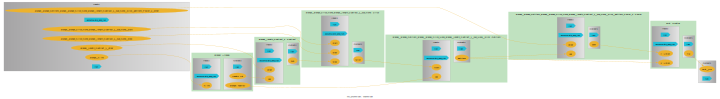

In [9]:
wf.draw(size=(10,10))

We can see that the workflow automatically exposes unconnected IO of its children and gives them a name based on the child node's name and that node's IO name. Further, the math and indexing we do automatically injects new nodes after the output. Note that even though we perform a slice on `wf.arange.outputs.arange` twice, only a single node is created and it simply gets reused -- the graph is aware of all the dynamically injected nodes and reuses them like this for computational efficiency.

Let's run our workflow and look at the result:

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/io.py:404: UserWarning: The keyword 'arrays__x' was not found among input labels. If you are trying to update a class instance keyword, please use attribute assignment directly instead of calling this method
  warnings.warn(


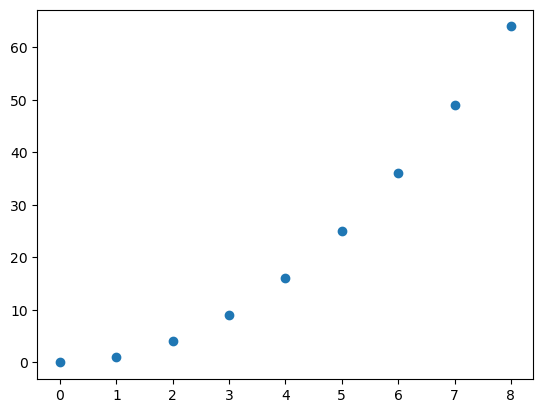

In [10]:
out = wf(arrays__x=5)
out.plot__fig

Unless it's turned off, `pyiron_workflow` will make sure that all new nodes and connections obey type hints (where provided). For instance, if we try to pass a non-int to our `square_range` node, we'll get an error:

In [11]:
try:
    wf.arange.inputs.x = 5.5
except TypeError as e:
    message = e.args[0]
    print(message)

Can only set Channel object or connect to existing channels, but the attribute x got assigned 5.5 of type <class 'float'>


## Composing complex workflows from macros

There's just one last step: once we have a workflow we're happy with, we can package it as a "macro"! This lets us make more and more complex workflows by composing sub-graphs.

We don't yet have an automated tool for converting workflows into macros, but we can create them by decorating a function that takes a macro instance and builds its graph, so we can just copy-and-paste our workflow above into a decorated function! 

Just like a function node, the IO of a macro is defined by the signature and return values of the function we're decorating. Just remember to include a `self`-like argument for the macro instance itself as the first argument, and (usually) to only return single-output nodes or output channels in the `return` statement:

In [12]:
@Workflow.wrap.as_macro_node("x", "n", "fig")
def MySquarePlot(macro, n: int):
    macro.arange = Arange(n=n)
    macro.plot = macro.create.plotting.Scatter(
        x=macro.arange.outputs.arange[:macro.arange.outputs.length -1],
        y=macro.arange.outputs.arange[:macro.arange.outputs.length -1]**2
    )
    return macro.arange.outputs.arange, macro.arange.outputs.length, macro.plot

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/io.py:404: UserWarning: The keyword 'type_hint' was not found among input labels. If you are trying to update a class instance keyword, please use attribute assignment directly instead of calling this method
  warnings.warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel user_input was not connected to n, andthus could not disconnect from it.
  warn(


{'square_plot__n': 10,
 'square_plot__fig': <matplotlib.collections.PathCollection at 0x132c9bd10>,
 'plus_one_square_plot__fig': <matplotlib.collections.PathCollection at 0x132d3dc10>}

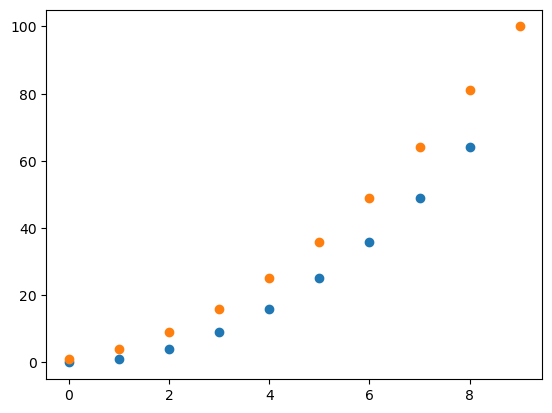

In [13]:
wf2 = Workflow("my_composed_workflow")

wf2.square_plot = MySquarePlot(n=10)
wf2.plus_one = wf2.square_plot.outputs.x + 1
wf2.plus_one_square_plot = wf2.create.plotting.Scatter(
    x=wf2.square_plot.outputs.x,
    y=wf2.plus_one**2,
)
wf2()

Meanwhile, we can see that our macro node IO is much tidier than the previous workflow IO now that when we're using the function-like definition, while the body of the graph is identical:

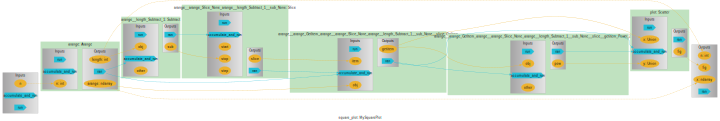

In [14]:
wf2.square_plot.draw(size=(10,10))

## What else?

To learn more, take a look at the `deepdive.ipynb` notebook, and/or start looking through the class docstrings. Here's a brief map of what you're still missing:

- Distributing node execution onto remote processes
  - Single core parallel python processes is available by setting the `.executor` attribute to a compatible executor instance, e.g. `Workflow.create.Executor()`
- Acyclic graphs
  - Execution for graphs whose data flow topology is a DAG happens automatically, but you're always free to specify this manually with `Signals`, and indeed _must_ specify the execution flow manually for cyclic graphs -- but cyclic graphs _are_ possible!
- Complex flow nodes
  - If, While, and For nodes are all available for more complex flow control
- Node libraries
  - Most of the current developments focus on running classical atomistics simulations
- Saving and loading finished calculations
  
### Features coming shortly
- Restarting partially executed workflows
- More and richer node packages

### Features planned
- "FAIR" principles for node packages and package registration
- Ontological typing and guided workflow design (see our `ironflow` project for a working prototype)